<a href="https://colab.research.google.com/github/ikonushok/My_studying_Data-Science-and-Neyro-Nets-on-Python/blob/master/%D0%94%D0%97_7_Ultra_%D0%9F%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BA%D0%BE%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%BE%D0%BA_PLZL_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ultra PRO задание
-------
Найдите любую базу с временными рядами и напишите прогнозирование этого ряда на 10 шагов:
1. Спарсите, разделите и нормализуйте данные
2. Разделите данные на обучающую и проверочную выборки
3. Напишите сеть для прогнозирования временного ряда
4. Сделайте визуализацию результата
5. Напишите ваши результаты и выводы

In [ ]:
#!pip install yfinance
#import yfinance as yf ## Библиотека для получения данных об акциях
# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
# (optional, default is '1d')
import yfinance as yf

In [ ]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import  Flatten, Conv1D, Conv2D, LSTM, Bidirectional, LeakyReLU
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, Adamax
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
from tensorflow.keras import utils
from keras.utils import plot_model

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/Занятие_7_Временные ряды/data')

## Подготовка данных

### Загружаем данные

In [ ]:
## Загрузка и сохранение первичных данных
tickers = ['PLZL.ME']
stock = yf.download(tickers,start='2017-01-01', interval = '1d')
del stock['Adj Close']
stock[-3:]
#stock['Adj Close'].head()
#stock['Date'].head()

# Polus Zoloto - 'PLZL.ME' - Россия
# Polimetal - POLY.ME - Россия

# df = stock.reset_index() # если надо перевести дату из индекса в значения

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2020-09-14,17077.5,17117.0,16778.0,16880.0,183042
2020-09-15,16980.0,17073.0,16776.0,16893.0,155579
2020-09-16,16938.5,17194.5,16886.0,17150.5,67267


In [ ]:
data = stock.pct_change() # Рассчитали дневную доходность
data.fillna(0, inplace=True) # Заменили NA значения на 0
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-04,0.009664,0.000000,-0.003383,0.000000,0.036626
2017-01-05,0.000890,0.001102,0.017195,0.005557,0.324411
2017-01-06,0.007341,-0.001542,0.004893,-0.000442,-0.723525
2017-01-09,0.000220,0.000220,-0.003762,-0.000442,2.333333


In [ ]:
data = stock.values
print(data.shape)

(930, 5)


### Рисуем график

In [ ]:
#!pip install --upgrade mplfinance
#import mplfinance as mpf  
# https://pypi.org/project/mplfinance/
# https://github.com/matplotlib/mplfinance/blob/master/examples/using_lines.ipynb
# https://github.com/matplotlib/mplfinance/blob/master/examples/external_axes.ipynb
# https://github.com/matplotlib/mplfinance/blob/master/examples/addplot.ipynb 


На графике показан диапазон провеки стратегии на данных, которые не видела Нейросеть
и на которых будет считаться прибыльность торговой стратегии на основе НС


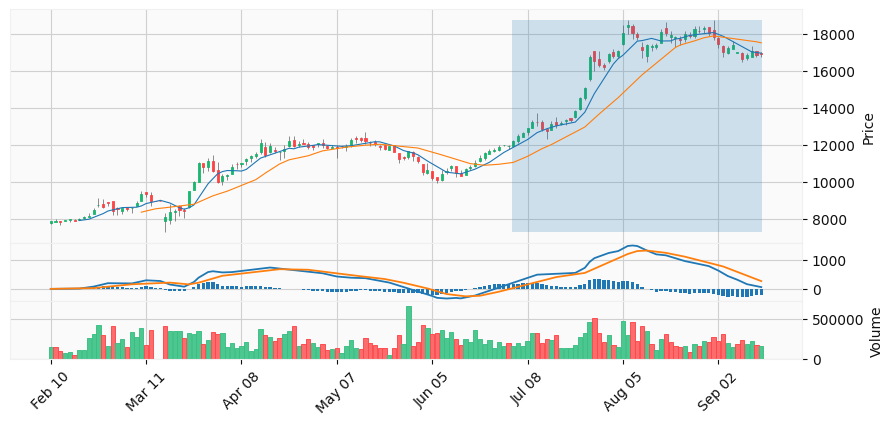

In [ ]:
print('\nНа графике показан диапазон провеки стратегии на данных, которые не видела Нейросеть')
print('и на которых будет считаться прибыльность торговой стратегии на основе НС')

# create a MACD plot (Moving Average Convergence Divergence)
exp12 = stock['Close'][-150:].ewm(span=12, adjust=False).mean()
exp26 = stock['Close'][-150:].ewm(span=26, adjust=False).mean()
macd = exp12 - exp26
signal = macd.ewm(span=9, adjust=False).mean()
histogram = macd - signal
apds = [mpf.make_addplot(histogram, type='bar', width=0.7,panel=1, secondary_y=False),
        mpf.make_addplot(macd,panel=1,secondary_y=False),
        mpf.make_addplot(signal,panel=1,secondary_y=False),
       ]

# А это обычный график:
mpf.plot(stock[-150:], figsize=(11, 5), main_panel=0, volume_panel=2, panel_ratios = (4,1,1),
         type = 'candle', volume = True, style = 'yahoo',
         vlines=dict(vlines='2020-08-10',linewidths = 180, alpha = 0.2),
         mav = (7, 20),
         addplot = apds,
         )

## Формирование выборок


In [ ]:
#Формируем параметры загрузки данных
xLen = 10                       #Анализируем по 20 прошедшим точкам 
valLen = 50                    #Используем 100 записей для проверки
stepsForward = 10
trainLen = data.shape[0]-valLen #Размер тренировочной выборки
batch_size = 1

In [ ]:
trainLen = data.shape[0]-valLen #Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain, xTest = data[:trainLen - stepsForward], data[trainLen+xLen+2: - stepsForward+1]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Для подготовки yTrain на 10 шагов вперед необходимо создать дополнительный датасет
yTrain = np.array([data[:trainLen,0][i:i + stepsForward] for i in range(trainLen - stepsForward)])
yTest = np.array([data[trainLen+xLen+2:,0][i:i + stepsForward] for i in range(valLen-xLen - stepsForward-1)])
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, sampling_rate=1, #Для каждой точки
                               batch_size=batch_size)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=batch_size)

In [ ]:
print(trainDataGen[10][0].shape,
      trainDataGen[10][1].shape)

(1, 10, 5) (1, 10)


In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) #Размер batch будет равен длине нашей выборки

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

## Визуализация результатов

In [ ]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) # Размер batch будет равен длине нашей выборки

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

## Нейросети

### CNN

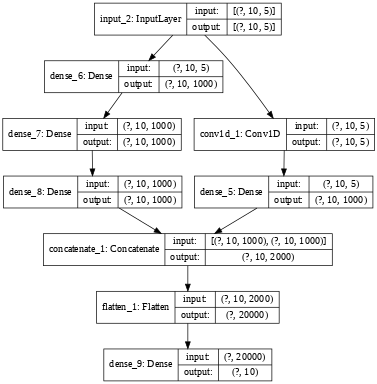

In [ ]:
input = Input(shape = (xLen, xTrain.shape[1]), )
x1 = Conv1D(5, 2, padding='same', activation='relu')(input)
x1 = Dense(1000, activation='linear')(x1)
#x1 = Flatten()(x1) # слой нужен, тк иначе не работают фукции проверки!!

x2 = Dense(1000, activation="linear")(input)
x2 = Dense(1000, activation="linear")(x2)
x2 = Dense(1000, activation="linear")(x2)
#x2 = Flatten()(x2) # слой нужен, тк иначе не работают фукции проверки!!

x = concatenate([x1, x2])
x = Flatten()(x) # слой нужен, тк иначе не работают фукции проверки!!
x = Dense(yTrain.shape[1], activation='linear')(x)
model = Model(input, x)

plot_model(model, dpi=50, show_shapes=True, show_layer_names=True)

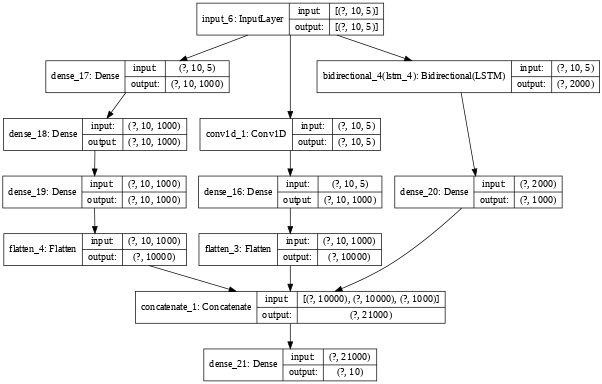

In [ ]:
input = Input(shape = (xLen, xTrain.shape[1]), )
x1 = Conv1D(5, 2, padding='same', activation='relu')(input)
x1 = Dense(1000, activation='linear')(x1)
x1 = Flatten()(x1)
#x1 = Flatten()(x1) # слой нужен, тк иначе не работают фукции проверки!!

x2 = Dense(1000, activation="linear")(input)
x2 = Dense(1000, activation="linear")(x2)
x2 = Dense(1000, activation="linear")(x2)
x2 = Flatten()(x2)
#x2 = Flatten()(x2) # слой нужен, тк иначе не работают фукции проверки!!

x3 = Bidirectional(LSTM(1000))(input) # хороший результат
x3 = Dense(1000, activation="linear")(x3)

x = concatenate([x1, x2, x3])
#x = Flatten()(x) # слой нужен, тк иначе не работают фукции проверки!!
x = Dense(yTrain.shape[1], activation='linear')(x)
model3 = Model(input, x)

plot_model(model3, dpi=50, show_shapes=True, show_layer_names=True)

#LSTM

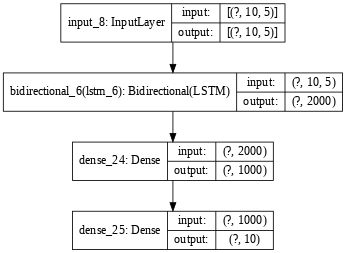

In [ ]:
input = Input(shape = (xLen,xTrain.shape[1]), )
x = Bidirectional(LSTM(1000))(input) # хороший результат
x = Dense(1000, activation="linear")(x)
x = Dense(yTrain.shape[1], activation='linear')(x)
modelBI = Model(input, x)

plot_model(modelBI, dpi=60, show_shapes=True, show_layer_names=True)
# ошибка при прогнозе 1.9749 0.8497 0.0719 -0.1305 -0.3831 0.0254 0.0182 0.0 0.0019 0.0027


In [ ]:
# Коллбэки
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 6, verbose = 0, restore_best_weights = True)
#Checkpoint = ModelCheckpoint('PLZL_Concatenate.h5', monitor = 'loss', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-06, verbose = 1)

model.compile(loss="mse", optimizer=RMSprop(lr=1e-4))

history = model.fit_generator(trainDataGen, epochs=30, verbose=1, 
    validation_data = testDataGen,
    callbacks = [early_stopping, reduce_lr]
    )

Epoch 1/30
860/860 [==============================] - 13s 15ms/step - loss: 0.0042 - val_loss: 0.0227
Epoch 2/30
860/860 [==============================] - 12s 14ms/step - loss: 0.0023 - val_loss: 0.0067
Epoch 3/30
860/860 [==============================] - 12s 14ms/step - loss: 0.0020 - val_loss: 0.1704
Epoch 4/30
860/860 [==============================] - 12s 14ms/step - loss: 0.0018 - val_loss: 0.0070
Epoch 5/30
857/860 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
860/860 [==============================] - 12s 14ms/step - loss: 0.0017 - val_loss: 0.0081
Epoch 6/30
860/860 [==============================] - 12s 14ms/step - loss: 0.0011 - val_loss: 0.0061
Epoch 7/30
860/860 [==============================] - 12s 14ms/step - loss: 0.0010 - val_loss: 0.0293
Epoch 8/30
860/860 [==============================] - 12s 14ms/step - loss: 0.0010 - val_loss: 0.0124
Epoch 9/30
860/860 [=================

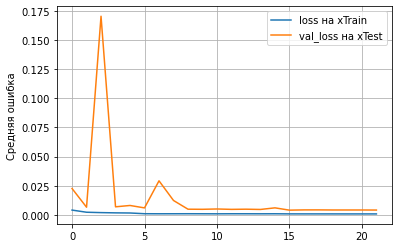

In [ ]:
plt.plot(history.history['loss'], 
         label='loss на xTrain')
plt.plot(history.history['val_loss'], 
         label='val_loss на xTest')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.grid()
plt.show()

**Отображаем результаты**

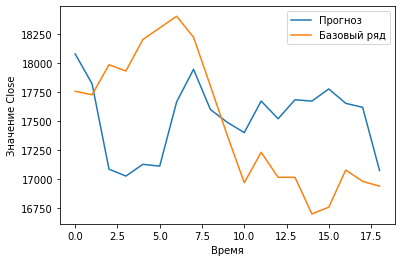

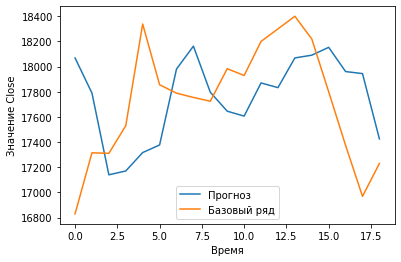

In [ ]:
#Прогнозируем данные текущей сетью
currModel = model
(predVal2, yValUnscaled2) = getPred(currModel, xVal[0], yVal[0], yScaler)
delta = predVal2 - yValUnscaled2

n = stepsForward-1 # число шагов предсказания - можно менять для глубины прогноза
#Отображаем графики
showPredict(0, valLen, n, predVal2, yValUnscaled2) #
showPredict(0, valLen, 2, predVal2, yValUnscaled2) # 

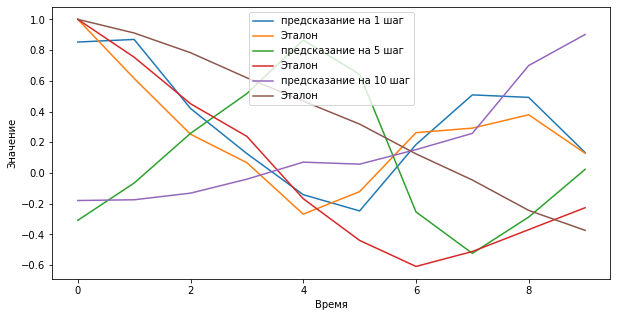

In [ ]:
#Отображаем корреляцию
plt.figure(figsize=(10,5))
showCorr([0, 4, 9], xLen, predVal2, yValUnscaled2) #учитывать число шагод на которые предсказываем!!
# увеличивать или уменьшать [0, 1, 2]

## Функция ошибки


In [ ]:
### Функция ошибки
def getError(x1, x2):
  dx = (x1-x2) ** 2        #Вычислем среднеквадратичную ошибку по точкам
  dxs = np.sort(dx)[::-1]  #Сортируем ошибку в порядке убывания
  return np.mean(dxs[:10]) #Итоговая ошибка равны среднему 10 самых больших ошибок на всём отрезке

In [ ]:
#Отображаем ошибку при прогнозе на несколько шагов вперёд
for i in range(stepsForward):
  x1 = predVal2[:,i]
  x2 = yValUnscaled2[:,i]

  print("Шаг", i+1, "ошибка", round(getError(x1, x2),3))

Шаг 1 ошибка 84838.278
Шаг 2 ошибка 373914.06
Шаг 3 ошибка 497154.573
Шаг 4 ошибка 509131.357
Шаг 5 ошибка 625861.682
Шаг 6 ошибка 577610.36
Шаг 7 ошибка 621971.796
Шаг 8 ошибка 613681.689
Шаг 9 ошибка 684901.061
Шаг 10 ошибка 789044.631


In [ ]:
### Функция ошибки

def getError2(x1, x2):
  corr = []
  yLen = x1.shape[0]

  #Вычисляем корреляцию выхода сети в верным ответом
  #Смещая выход сети назад от 0 до 9 шагов
  for i in range(10):
    corr.append(correlate(x1[:yLen-i], x2[i:]))
  
  corr = np.array(corr)
  
  #Возвращаем функцию ошибки, как произведение
  #1 - корреляции без смещения (со смещением на 0)
  #2 - того, во сколько раз корреляция без смещения больше, чем средняя корреляция при смещении на 1-5 шагов
  return corr[0] * (corr[0] / np.max(corr[1:10]))

In [ ]:
#Отображаем ошибку при прогнозе на несколько шагов вперёд
for i in range(stepsForward):
  x1 = predVal2[:,i]
  x2 = yValUnscaled2[:,i]

  print(round(getError2(x1, x2),4))

2.3205
1.1875
0.1546
-0.1626
-0.4861
-3.5572
0.0083
0.045
0.0658
0.0986


In [ ]:
#Сравнимаем две модели по новой функции ошибки
#При предсказании на несколько шагов вперёд
model1 = model3
model2 = modelBI

#Получаем предсказания от обеих сетей
predValM1 = yScaler.inverse_transform(model1.predict(xVal[0]))
predValM2 = yScaler.inverse_transform(model2.predict(xVal[0]))
yValUnscaled3 = yScaler.inverse_transform(yVal)

#Здаём собственную функцию ошибки
errorFunc = getError2

for i in range(stepsForward):
  x1 = predValM1[:,i]
  x2 = predValM2[:,i]
  x = yValUnscaled2[:,i]

  print("Предсказание на", i+1, "шагов: M1 =", round(errorFunc(x1, x),3), "M2 =", round(errorFunc(x2, x),3))

ValueError: ignored